# Description VQA

In [ ]:
 '''
 OUR MODEL
Input: VQA2, Train: mscoco2014 train, Validation mscoco2014 val ,Test mscoco2015 test
https://visualqa.org/download.html
Trainval images: 123287(82,783 + 40,504)Trianval questions: 658111
Test images: 81434 Test questions:  447793 Test-dev images: 36807
Unique answers is 3133

Paper: 204,721 images from Microsoft COCO dataset,(443,757 train, 214,354 val, and 447,793 test questions)
DIFFERENCE :n_ans = 3133, only answers which appear more than 8 times in val+train dataset
Github : https://github.com/cvlab-tohoku/Dense-CoAttention-Network/blob/master/dense_coattn/cost/costs.py
 '''
    
'''
this model use PNASNet for visual feature selection and use dense layer to select the 
'''
    

In [1]:
import tensorflow as tf
import os
import sys
import cv2
import numpy as np
import tensorflow.contrib.slim as slim
import tensorflow_hub as hub
from utils import *
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options,log_device_placement=True, allow_soft_placement=True)
import lmdb
%matplotlib inline
import matplotlib.pyplot as plt
import random
import pickle
#from bert_embedding import BertEmbedding

os.environ["TFHUB_CACHE_DIR"] = "/home/sonam/tfhub_modules"
# Jupyter caches the utils module, so changes there aren't reflected in a re-import. We delete the utils module from
# sys.modules first so that we force-reload all the code in utils.py

if 'utils' in sys.modules:
    del sys.modules['utils']
from utils import *
print('import done')


/home/sonam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


import done


In [2]:
print(tf.contrib.eager.num_gpus())

1


In [3]:
!pip install bert-tensorflow

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Loading Data

In [5]:
base_path = '/dvmm-filer2/datasets/Groundings/data/'
data_path = base_path + 'mscoco/'
lmdb_path = data_path + 'MSCOCO_jpg.lmdb'
lmdb_path_new = '/home/sonam/mscoco_test2015' 

dict_paths = {'train':'trainval.pickle', 'val':'val.pickle', 'test': 'test.pickle'} 
ans_paths = 'top_answer_list.pickle'

In [6]:
with open(dict_paths['train'], 'rb') as f:
    dict_train = pickle.load(f, encoding='latin1')
    ids_train = list(dict_train.keys())

In [7]:
dict_paths['train']

'trainval.pickle'

In [8]:
#loading MSCOCO img data 
lmdb_env = lmdb.open(lmdb_path, map_size=int(1e11), readonly=True, lock=False)
txn = lmdb_env.begin(write=False)
lmdb_env_test = lmdb.open(lmdb_path_new, map_size=int(1e11), readonly=True, lock=False)
txn_test = lmdb_env_test.begin(write=False)
with open(dict_paths['train'], 'rb') as f:
    dict_train = pickle.load(f, encoding='latin1')
    ids_train = list(dict_train.keys())
    
# with open(ans_paths,'rb') as f:
#     unique_ans = pickle.load(f, encoding='latin1')
    
# with open(dict_paths['val'], 'rb') as f:
#     dict_val = pickle.load(f, encoding='latin1')
#     ids_val = list(dict_val.keys())

with open("./idx2ans.pickle", 'rb') as file:
    idx2ans = pickle.load(file)
    
with open(dict_paths['test'], 'rb') as f:
    dict_test = pickle.load(f, encoding='latin1')
    ids_test = list(dict_test.keys())

print('training image size', len(ids_train))
#print('validation image size', len(ids_val))
print('testing image size', len(ids_test))

training image size 123287
testing image size 81434


In [9]:
#print(len(idx2ans))
with open(dict_paths['test'], 'rb') as f:
    dict_test = pickle.load(f, encoding='latin1')
    ids_test = list(dict_test.keys())

In [10]:
#print(dict_train.keys())
print(dict_train['393227'])
for i, annot in enumerate(dict_train['393227']):
    k = list(annot.keys())
    print(k, i, annot[k[0]])

[{393227000: {'question': 'does the guy have a tattoo ?', 'answer': [(['yes'], 1)], 'answer_id': [(3, 1)]}}, {393227001: {'question': 'what is this man riding on ?', 'answer': [(['skateboard'], 1)], 'answer_id': [(11, 1)]}}, {393227002: {'question': "how many tattoos can be seen on this man 's body ?", 'answer': [(['1'], 1), (['3'], 0.3), (['2'], 0.3)], 'answer_id': [(12, 1), (32, 0.3), (17, 0.3)]}}, {393227003: {'question': 'what color is his hat ?', 'answer': [(['backwards'], 0.3), (['blue'], 1)], 'answer_id': [(2497, 0.3), (13, 1)]}}, {393227004: {'question': "is the man 's visor providing his face enough protection ?", 'answer': [(['no'], 1)], 'answer_id': [(9, 1)]}}]
[393227000] 0 {'question': 'does the guy have a tattoo ?', 'answer': [(['yes'], 1)], 'answer_id': [(3, 1)]}
[393227001] 1 {'question': 'what is this man riding on ?', 'answer': [(['skateboard'], 1)], 'answer_id': [(11, 1)]}
[393227002] 2 {'question': "how many tattoos can be seen on this man 's body ?", 'answer': [(['

In [ ]:
print(dict_test['262144'])
for i, annot in enumerate(dict_test['262144']):
    k = list(annot.keys())
    print(annot[k[0]])


In [ ]:
# Test Image
i = 1
id_train = ids_train[i]
print(id_train)
print(txn)
imgbin = txn.get(id_train.encode('utf-8'))
buff = np.frombuffer(imgbin, dtype='uint8') 
#print(buff)
imgbgr = cv2.imdecode(buff, cv2.IMREAD_COLOR)
img = imgbgr[:,:,[2,1,0]]
im = cv2.resize(img,(299,299)) 
print(im.shape)
plt.imshow(im)

In [25]:
# Storing images in memory
def preprocess_images(all_ids_list, db, db2):
    valid_ids = []
    images_dict = {}
    for i, id_train in enumerate(all_ids_list):
        imgbin = db.get(id_train.encode('utf-8'))
        if imgbin == None:
            imgbin = db2.get(id_train.encode('utf-8'))
            if imgbin == None:
                raise Exception("image not found! %s" % id_train)
        buff = np.frombuffer(imgbin, dtype='uint8')        
        imgbgr = cv2.imdecode(buff, cv2.IMREAD_COLOR)
        img = imgbgr[:,:,[2,1,0]]
        im = cv2.resize(img,(299,299))  
        valid_ids.append(id_train)
        images_dict[id_train] = im
        if i % 3000 == 0:
            print('Processed: ', i, ' images')
    print('Done pre-processing images')            
    return valid_ids, images_dict

In [26]:
# Preprocessing Training Images
valid_ids_train, train_images = preprocess_images(ids_train, txn,txn_test)
print('Done pre-processing training images')

Processed:  0  images
Processed:  3000  images
Processed:  6000  images
Processed:  9000  images
Processed:  12000  images
Processed:  15000  images
Processed:  18000  images
Processed:  21000  images
Processed:  24000  images
Processed:  27000  images
Processed:  30000  images
Processed:  33000  images
Processed:  36000  images
Processed:  39000  images
Processed:  42000  images
Processed:  45000  images
Processed:  48000  images
Processed:  51000  images
Processed:  54000  images
Processed:  57000  images
Processed:  60000  images
Processed:  63000  images
Processed:  66000  images
Processed:  69000  images
Processed:  72000  images
Processed:  75000  images
Processed:  78000  images
Processed:  81000  images
Processed:  84000  images
Processed:  87000  images
Processed:  90000  images
Processed:  93000  images
Processed:  96000  images
Processed:  99000  images
Processed:  102000  images
Processed:  105000  images
Processed:  108000  images
Processed:  111000  images
Processed:  114

In [ ]:
# Preprocessing Validation Images
# valid_ids_val, val_images = preprocess_images(ids_val, txn, txn_test)
# print('Done pre-processing validation images')

In [27]:
print('valid_trainids', len(valid_ids_train))
#print('valid ids vals', len(valid_ids_val))

valid_trainids 123287


In [28]:
print('sonam')

sonam


# Attention

In [11]:
# this method select the attendance feature which has the highest score
def new_fusion(v, e_s):
     with tf.variable_scope('new_loss'):
            ###sentence-level###
            #heatmap pool
            h_s = tf.nn.relu(tf.einsum('bj,blkj->blk',e_s,v)) #pair-wise e_bar*v^T: ?xNx4
            #attention
            a_s = tf.einsum('bjk,bjki->bik',h_s,v) #?xDx4 attnded visual reps for sen.
            #pair-wise score
            a_s_norm = tf.nn.l2_normalize(a_s,axis=1) # ? *D*4
            e_s_norm = tf.nn.l2_normalize(e_s,axis=1) # ?*D

            R_sk = tf.einsum('bik,bi->bk',a_s_norm,e_s_norm) #cosine for (sen,img_reps)
            R_sk = tf.identity(R_sk,name='level_score_sentence')
            #R_s = tf.reduce_max(R_sk,axis=-1,name='score_sentence') #?
            #heatmap
            idx_k = tf.argmax(R_sk,axis=-1,name='level_index_sentence') #? index of the featuremap which maximizes R_i
            idx_k = tf.cast(idx_k, tf.int32)
            
            batch_size_tensor = tf.shape(a_s)[0]
            #dim_tensor = tf.shape(a_s)[1]
            dim_tensor = 1024
            
            ii, jj = tf.meshgrid(tf.range(batch_size_tensor), tf.range(dim_tensor), indexing='ij')
            kk, ll = tf.meshgrid(idx_k, tf.range(dim_tensor), indexing='ij')
            ii = tf.cast(ii, tf.int64)
            jj = tf.cast(jj, tf.int64)
            kk = tf.cast(kk, tf.int64)            
            c = tf.stack([tf.reshape(ii, (-1,)), tf.reshape(jj, (-1,)), tf.reshape(kk, (-1,))], axis=1)
            c = tf.reshape(c, (batch_size_tensor, dim_tensor, 3))

            best_visual = tf.gather_nd(a_s_norm, c)
            fusion = tf.concat([e_s_norm, best_visual], axis=1)    #?*2D
            return fusion

# this method use score as weight for calculating the average of attendance feature
def new_fusion_avg(v, e_s):
     with tf.variable_scope('new_loss'):
            ###sentence-level###
            #heatmap pool
            h_s = tf.nn.relu(tf.einsum('bj,blkj->blk',e_s,v)) #pair-wise e_bar*v^T: ?xNx4
            #attention
            a_s = tf.einsum('bjk,bjki->bik',h_s,v) #?xDx4 attnded visual reps for sen.
            #pair-wise score
            a_s_norm = tf.nn.l2_normalize(a_s,axis=1) # ? *D*4
            e_s_norm = tf.nn.l2_normalize(e_s,axis=1) # ?*D

            R_sk = tf.einsum('bik,bi->bk',a_s_norm,e_s_norm) #cosine for (sen,img_reps)
            R_sk = tf.identity(R_sk,name='level_score_sentence')
            
            R_sk = tf.expand_dims(R_sk, 2)
            
            visual = tf.matmul(a_s_norm, R_sk)
            visual = tf.squeeze(visual,[-1])
            fusion = tf.concat([e_s_norm, visual], axis=1)    #?*2D
            return fusion

# this method feeds four attendance features to dense layer to generate a new attendance feature 
def new_fusion_learn(v, e_s):
     with tf.variable_scope('new_loss'):
            ###sentence-level###
            #heatmap pool
            h_s = tf.nn.relu(tf.einsum('bj,blkj->blk',e_s,v)) #pair-wise e_bar*v^T: ?xNx4
            #attention
            a_s = tf.einsum('bjk,bjki->bik',h_s,v) #?xDx4 attnded visual reps for sen.
            #pair-wise score
            a_s_norm = tf.nn.l2_normalize(a_s,axis=1) # ? *D*4
            e_s_norm = tf.nn.l2_normalize(e_s,axis=1) # ?*D

            visual = tf.contrib.layers.flatten(a_s_norm)
            visual = tf.layers.dense(visual, units=1024)
            visual = tf.nn.leaky_relu(visual,alpha=.25)
            visual = tf.layers.dense(visual, units=e_s_norm.get_shape().as_list()[1])
            
            fusion = tf.concat([e_s_norm, visual], axis=1)    #?*2D
            return fusion        
    
def build_bilstm(w_embd,seq_length):
    with tf.variable_scope('BiLSTM'):
        # Forward direction cell
        lstm_fw_cell = tf.contrib.rnn.LSTMCell(512, forget_bias=1.0)
        # Backward direction cell
        lstm_bw_cell = tf.contrib.rnn.LSTMCell(512, forget_bias=1.0)
        outputs, _ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell, w_embd, sequence_length = seq_length,
                                                  dtype=tf.float32)
    output = tf.concat(outputs,axis=2,name='BiLSTM_out')
    return output

# Conv Functions

In [12]:
def add_3by3_conv(feat_map,n_layers,n_filters,name,regularizer):
    with tf.variable_scope(name+'_postConv'):
        for i in range(n_layers):
            with tf.variable_scope(name+'_stage_'+str(i)):
                feat_map = tf.layers.conv2d(feat_map, filters=n_filters[i], kernel_size=[3,3],
                                            kernel_regularizer=regularizer, padding='same')
                feat_map = tf.nn.leaky_relu(feat_map, alpha=.25)
    return feat_map


# def depth_selection(model, conv_kernel_size=3, n_layers = 3):
#     conv_method = None
#     if conv_kernel_size == 1:
#         conv_method = add_1by1_conv
#     elif conv_kernel_size == 3:
#         conv_method = add_3by3_conv
#     else:
#         raise ValueError('Invalid conv_kernel_size parameter. Should be either 1 or 3.')
#     with tf.variable_scope('stack_v'):
#         v1 = tf.identity(model['vgg_16/conv5/conv5_1'],name='v1')
#         v1 = conv_method(v1, n_layers, n_filters=[1024,1024,1024], name='v1', regularizer=regularizer)
# #         n_filters=[1024]
#         size = v1.get_shape().as_list()[1:3]
#         resize_method = tf.image.ResizeMethod.BILINEAR
#         v2 = tf.identity(model['vgg_16/conv5/conv5_3'],name='v2')
#         v2 = tf.image.resize_images(v2, size, method=resize_method)
#         v2 = conv_method(v2,n_layers,n_filters=[1024,1024,1024],name='v2',regularizer=regularizer)
#         v3 = tf.identity(model['vgg_16/conv4/conv4_1'],name='v3')
#         #new
#         #v3 = tf.layers.max_pooling2d(v3,[2,2],strides=2)
#         #old
#         v3 = tf.image.resize_images(v3, size, method=resize_method)
#         v3 = conv_method(v3,n_layers,n_filters=[1024,1024,1024],name='v3',regularizer=regularizer)
#         v4 = tf.identity(model['vgg_16/conv4/conv4_3'],name='v4')
#         v4 = tf.image.resize_images(v4, size, method=resize_method)
#         #new
#         #v4 = tf.layers.max_pooling2d(v4,[2,2],strides=2)
#         v4 = conv_method(v4,n_layers,n_filters=[1024,1024,1024],name='v4',regularizer=regularizer)
#         v_all = tf.stack([v1,v2,v3,v4], axis=3)
#         v_all = tf.reshape(v_all,[-1,v_all.shape[1]*v_all.shape[2],v_all.shape[3],v_all.shape[4]])
#         v_all = tf.nn.l2_normalize(v_all, axis=-1, name='stacked_image_feature_maps')
#     return v_all

def depth_selection_with_maxpool_pnasnet(model, conv_kernel_size=3, n_layers = 3):
    conv_method = None
    if conv_kernel_size == 1:
        conv_method = add_1by1_conv
    elif conv_kernel_size == 3:
        conv_method = add_3by3_conv
    else:
        raise ValueError('Invalid conv_kernel_size parameter. Should be either 1 or 3.')
    with tf.variable_scope('stack_v'):
        v1 = tf.identity(model['Cell_5'],name='v1')
        v1 = conv_method(v1,n_layers,n_filters=[1024],name='v1',regularizer=regularizer)
        size = v1.get_shape().as_list()[1:3]
        resize_method = tf.image.ResizeMethod.BILINEAR
        v2 = tf.identity(model['Cell_7'],name='v2')
       #v2 = tf.image.resize_images(v2, size, method=resize_method)
        v2 = conv_method(v2,n_layers,n_filters=[1024],name='v2',regularizer=regularizer)
        v3 = tf.identity(model['Cell_9'],name='v3')
        v3 = tf.image.resize_images(v3, size, method=resize_method)
        v3 = conv_method(v3,n_layers,n_filters=[1024],name='v3',regularizer=regularizer)
        v4 = tf.identity(model['Cell_11'],name='v4')
        v4 = tf.image.resize_images(v4, size, method=resize_method)
        v4 = conv_method(v4,n_layers,n_filters=[1024],name='v4',regularizer=regularizer)
        v_all = tf.stack([v1,v2,v3,v4], axis=3)
        v_all = tf.reshape(v_all,[-1,v_all.shape[1]*v_all.shape[2],v_all.shape[3],v_all.shape[4]])
        v_all = tf.nn.l2_normalize(v_all, axis=-1, name='stacked_image_feature_maps')
    return v_all

# Params

In [24]:
n_batch = 32
reg_val = .0005
n_layers = 1
conv_kernel_size = 3
n_ans = 3133
lr_value_0 = .0001
n_epochs = 20
n_iter_per_epoch = int(len(dict_train) / n_batch)
MAX_SEQ_LENGTH = 50
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
condition = 'VQA_MainFile_LSTM_learnable_fuse-3moredense_epoch15-PNASNet' + str(n_layers) +'bert_finetune'

In [14]:
def tf_print(tensor, transform=None):

    # Insert a custom python operation into the graph that does nothing but print a tensors value 
    def print_tensor(x):
        # x is typically a numpy array here so you could do anything you want with it,
        # but adding a transformation of some kind usually makes the output more digestible
        print(x if transform is None else transform(x))
        return x
    
    log_op = tf.py_func(print_tensor, [tensor], [tensor.dtype])[0]
    with tf.control_dependencies([log_op]):
        res = tf.identity(tensor)

    # Return the given tensor
    return res

#  Build Graph Using PreTrained Attention Model

In [ ]:
# sess.close()
# tf.reset_default_graph()

In [ ]:
# try:
#     sess.close()
# except NameError:
#     print("Definining session for the first time")
# tf.reset_default_graph()
# condition = 'model_Performance_AttnGrnd_VGG_Depth_Max_VG_3by3_resize_nlayer1'
# print('Loading grounding pretrained model...')
# model_path = '../saved_models/'+ condition
# print(model_path)
# #model_path = '../model_CNN_avg'
# sess, graph = load_model(model_path,config)
# print('Model Loaded')

In [ ]:
# saved_model_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
# print(len(saved_model_variables))
# visual_model_variables = []
# for x in saved_model_variables:
#     if 'vgg_16' in str(x):
#         visual_model_variables.append(x)   
# print(len(visual_model_variables))
# print(type(visual_model_variables))
# print(type(saved_model_variables))

In [ ]:
# def get_names(graph=tf.get_default_graph()):
#     return [t.name for op in graph.get_operations() for t in op.values()]
# print(get_names())

In [ ]:
# v = sess.graph.get_tensor_by_name("stack_v/stacked_image_feature_maps:0")
# e_s = sess.graph.get_tensor_by_name("sen_embedding:0")
# fusion = new_fusion(v, e_s)

# #with tf.variable_scope('VQAClassifier'):
# fusion = tf.layers.dense(fusion, units=1024)
# fusion = tf.nn.leaky_relu(fusion,alpha=.25)
# fusion = tf.layers.dense(fusion, units=n_ans)
# fusion = tf.identity(fusion, name='fusion')
# #answer_batch = tf.placeholder('int64', shape=[None], name='answer_input')
# answer_batch = tf.placeholder(tf.float32, shape=[n_batch, n_ans], name='answer_input')
# #loss = tf.losses.sparse_softmax_cross_entropy(logits=fusion, labels=answer_batch)
# # loss = attn_loss(e_w,v,e_s) + tf.losses.get_regularization_loss()
# loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=fusion, labels=answer_batch)
# loss = tf.reduce_mean(loss)
# loss = tf.identity(loss, name='loss')

# tf.summary.scalar('loss_value', loss)
# lr = tf.placeholder(tf.float32, shape=[], name='learning_rate')
# tf.summary.scalar('learning_rate', lr)
# opt = tf.train.AdamOptimizer(lr)


# train_vars = list(set(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) - set(visual_model_variables))
# for x in train_vars:
#     print(x)
    
# train_op = opt.minimize(loss, var_list=train_vars, name='train_op')

# global_saver = tf.train.Saver()
    
# train_writer = tf.summary.FileWriter('./logs/vgg/vg', sess.graph)
# merged = tf.summary.merge_all()
# print('Model is built')

In [ ]:
#print(tf.__version__)

In [ ]:
# for x in train_vars:
#     print(x)

# Build Graph (Base)


In [34]:
try:
    sess.close()
except NameError:
    print("Definining session for the first time")
tf.reset_default_graph()

sess = tf.InteractiveSession(config=config)
# T: max_length, D = 1024
with tf.device('/gpu:0'):
    
    bert_module = hub.Module(BERT_MODEL_HUB, trainable=True)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                tokenization_info["do_lower_case"]])
    tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)


    mode = tf.placeholder(tf.string, name='mode')
    isTraining = tf.equal(mode, 'train')
    regularizer = tf.contrib.layers.l2_regularizer(reg_val)
    #Building visual model
    print('Building Visual Model...')
    input_img = tf.placeholder(tf.float32, (None,299,299,3), name='input_img')
    
#     #For VG Training
#     pre_processed_img = pre_process(input_img, 'vgg_preprocessing')
#     vis_model = pre_trained_load(model_name='vgg_16', image_shape=(None,299,299,3),
#                               input_tensor=pre_processed_img, session=sess, is_training=False, global_pool=True)
#     v = depth_selection(vis_model, conv_kernel_size = 3, n_layers = n_layers) #(?,1225,4,1024)

#     For PNAS Net Training
    pre_processed_img = pre_process(input_img, 'inception_preprocessing')
    vis_model = pre_trained_load(model_name='pnasnet_large', image_shape=(None,299,299,3),
                                 input_tensor=pre_processed_img, session=sess, is_training=False, global_pool=True)
    v = depth_selection_with_maxpool_pnasnet(vis_model, n_layers = n_layers) #(?,1225,4,1024)

    #Building text model
    print('Building Text Model...')
    #sentence placeholder - list of sentences
#     text_batch = tf.placeholder('string', shape=[None], name='text_input')
#     #loading pre-trained ELMo
#     elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
#     #getting ELMo embeddings
#     print('Loading Embeddings')
#     elmo_embds = elmo(text_batch, signature="default", as_dict=True)
#     lstm1_embd = elmo_embds['lstm_outputs1'] #?xTXD
#     lstm2_embd = elmo_embds['lstm_outputs2'] #?xTXD
#     w_embd = tf.identity(elmo_embds['elmo'], name='elmo_word_embd') #?xTXD
#     #taking index of last word in each sentence
#     idx = elmo_embds['sequence_len']-1 # [l1,l2,.....?]-1
    
#     #tf.size(idx) :batchsize
#     batch_idx = tf.stack([tf.range(0,tf.size(idx),1),idx],axis=1) # batchsize*2 , 1 col: 0,1,2... 2 col: lengths-1
    
#     # Concatenate first of backward with last of forward to get sentence embeddings
#     print('Getting Sentence Embeddings')
#     dim = lstm1_embd.get_shape().as_list()[-1] #?,?, 1024
    
#     sen_embd_1 = tf.concat([lstm1_embd[:,0,int(dim/2):],
#                             tf.gather_nd(lstm1_embd[:,:,:int(dim/2)],batch_idx)], axis=-1) #[batch,dim]
    
#     sen_embd_2 = tf.concat([lstm2_embd[:,0,int(dim/2):],
#                             tf.gather_nd(lstm2_embd[:,:,:int(dim/2)],batch_idx)], axis=-1) #[batch,dim]
    
#     sen_embd = tf.concat([tf.expand_dims(sen_embd_1,axis=2),
#                                tf.expand_dims(sen_embd_2,axis=2)], axis=2, name='elmo_sen_embd') #[batch,dim]
    
#     e_s = tf.layers.dense(sen_embd,units=1,use_bias=False) #?xDx1

#     e_s = tf.squeeze(e_s,axis=2) #?*D
#     e_s = tf.layers.dense(e_s, units=1024)
#     e_s = tf.nn.leaky_relu(e_s,alpha=.25)
#     e_s = tf.layers.dense(e_s, units=1024)
#     e_s = tf.nn.leaky_relu(e_s,alpha=.25) #?*D
#     e_s = tf.nn.l2_normalize(e_s, axis=-1, name='sen_embedding')
    

#     e_w = tf.layers.dense(w_embd, units=1024) #?xTXD
#     e_w = tf.nn.leaky_relu(e_w,alpha=.25)
#     e_w = tf.layers.dense(e_w, units=1024)
#     e_w = tf.nn.leaky_relu(e_w,alpha=.25)
#     e_w = tf.nn.l2_normalize(e_w, axis=-1, name='w_embedding') #?xTXD
   

     
#     #sentence placeholder - list of sentences
#     #text_batch = tf.placeholder('string', shape=[None], name='text_input')
    #loading pre-trained Bert
    input_ids = tf.placeholder("int32", shape=[None,MAX_SEQ_LENGTH], name='input_ids_input')
    input_mask = tf.placeholder("int32", shape=[None,MAX_SEQ_LENGTH], name='input_mask_input')
    segment_ids = tf.placeholder("int32", shape=[None,MAX_SEQ_LENGTH], name='segment_ids_input')
    bert_inputs = dict(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)
    bert_outputs = bert_module(bert_inputs, signature="tokens", as_dict=True)
    sen_embd = bert_outputs["pooled_output"]
    #sequence_output = bert_outputs["sequence_output"]
    #sen_embd = tf.placeholder('float', shape=[None, 768], name='text_input')
    
    
#     w_embd = tf.identity(elmo_embds['word_emb'], name='elmo_word_embd') #?xTxD/2
#     lstm_embd = build_bilstm(w_embd,elmo_embds['sequence_len']) #?xTxD
    
#     #taking index of last word in each sentence
#     idx = elmo_embds['sequence_len']-1
#     batch_idx = tf.stack([tf.range(0,tf.size(idx),1),idx],axis=1)
#     # Concatenate first of backward with last of forward to get sentence embeddings
#     dim = lstm_embd.get_shape().as_list()[-1]
#     sen_embd = tf.concat([lstm_embd[:,0,int(dim/2):],
#     tf.gather_nd(lstm_embd[:,:,:int(dim/2)],batch_idx)], axis=-1) #[batch,dim]

    e_s = tf.layers.dense(sen_embd, units=1024)
    e_s = tf.nn.leaky_relu(e_s,alpha=.25)
    e_s = tf.layers.dense(e_s, units=1024)
    e_s = tf.nn.leaky_relu(e_s,alpha=.25)
    e_s = tf.nn.l2_normalize(e_s, axis=-1, name='sen_embedding')

#     w_embd_tiled = tf.tile(w_embd,[1,1,2])
#     w_embd = tf.concat([tf.expand_dims(w_embd_tiled,axis=3),tf.expand_dims(lstm_embd,axis=3)],axis=3)
#     w_embd = tf.layers.dense(w_embd, units=1)[:,:,:,0]
#     e_w = tf.layers.dense(w_embd, units=1024)
#     e_w = tf.nn.leaky_relu(e_w,alpha=.25)
#     e_w = tf.layers.dense(e_w, units=1024)
#     e_w = tf.nn.leaky_relu(e_w,alpha=.25)
#     e_w = tf.nn.l2_normalize(e_w, axis=-1, name='w_embedding')
    
    
# print('Generating Heatmaps')
   # heatmap_w,heatmap_s,R_i,R_s = attn(e_w,v,e_s)
    
    with tf.variable_scope('VQAClassifier'):
        fusion = new_fusion_learn(v, e_s)
        fusion = tf.layers.dense(fusion, units=1024)
        fusion = tf.nn.leaky_relu(fusion,alpha=.25)
        fusion = tf.layers.dense(fusion, units=1024)
        fusion = tf.nn.leaky_relu(fusion,alpha=.25)
        fusion = tf.layers.dense(fusion, units=1024)
        fusion = tf.nn.leaky_relu(fusion,alpha=.25)
        fusion = tf.layers.dense(fusion, units=1024)
        fusion = tf.nn.leaky_relu(fusion,alpha=.25)
        fusion = tf.layers.dense(fusion, units=n_ans)
        fusion = tf.identity(fusion, name='fusion')
    
    answer_batch = tf.placeholder(tf.float32, shape=[n_batch, n_ans], name='answer_input')
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=fusion, labels=answer_batch)
    loss = tf.reduce_mean(loss)
    loss = tf.identity(loss, name='loss')

    tf.summary.scalar('loss_value', loss)

    lr = tf.placeholder(tf.float32, shape=[], name='learning_rate')
    tf.summary.scalar('learning_rate', lr)
    opt = tf.train.AdamOptimizer(lr)

    train_vars = list(set(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)) - set(vis_model.model_weights))
    train_op = opt.minimize(loss, var_list=train_vars, name='train_op') 

    train_writer = tf.summary.FileWriter('./logs/vgg/vg', sess.graph)
    merged = tf.summary.merge_all()
    print('Model is built')

Building Visual Model...
Building Text Model...
Model is built


In [ ]:
# if restoring variables
# condition = 'model_Performance_AttnGrnd_VGG_Depth_Max_VG_3by3_resize_nlayer1'
# ckpt_path = '../saved_models/'+ condition   
# vars_to_restore = []
# vars_to_initialize = []
# for x in tf.global_variables():
#     if 'VQAClassifier' not in str(x):
#         vars_to_restore.append(x) 
#     else:
#         vars_to_initialize.append(x)

In [ ]:
for x in train_vars:
    print(x)

In [ ]:
# for x in tf.global_variables():
#     print(x)

# Batch Gen

In [16]:
def batch_gen(valid_ids, annot_dict, train_images,n_batch):
    img_batch = np.empty((n_batch, 299, 299, 3), dtype='float32')
    cap_batch = []
    ans_batch = []
    chosen_ids = random.sample(valid_ids, n_batch)
    for i, chosen_id in enumerate(chosen_ids):
        imgbin = train_images[chosen_id]
        img_batch[i,:,:,:] = imgbin
        questions = []
        answers = []
        for annot in annot_dict[chosen_id]:
            q_id = list(annot.keys())[0] 
            questions.append(annot[q_id]['question'])
            label = np.zeros(3133, dtype='float32')
            for answer in annot[q_id]['answer_id']:
                label[answer[0]] = answer[1]
            answers.append(label)
        n_ques = len(questions)
        idx = random.choice(range(n_ques))  
        cap_batch.append(questions[idx])
        ans_batch.append(answers[idx])
        
    return img_batch, cap_batch, ans_batch

def preprocessbertinputs(text_batch, tokenizer):
    label_list = [0,1]
    train_InputExamples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in text_batch ]
    train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer) 
    input_ids_bert =  [x.input_ids for x in train_features]
    input_mask_bert = [x.input_mask for x in train_features]
    segment_ids_bert = [x.segment_ids for x in train_features]
    return input_ids_bert, input_mask_bert, segment_ids_bert

def bert_sentenceembedding(text_batch,bert_embedding):
    n_batch = len(text_batch)
    sen_emb = np.zeros(n_batch, 768)
    result = bert_embedding(text_batch)
    sen_embd = [sum(x[1])/len(x[1]) for x in result]
    return sen_embd

# Validation

In [17]:
class Question:
    def __init__(self,question_id,image_id,question,answer_id=None):
        self.question_id = question_id
        self.image_id = image_id
        self.question = question
        self.answer_id = answer_id

In [18]:
# #Generating All Questions in Validation Batch
# final_val_list = []
# for k, doc_id in enumerate(dict_val):
#     image_id = doc_id
#     for annot in dict_val[doc_id]:
#         question_id = list(annot.keys())[0]
#         question = annot[question_id]['question']
#         answer_id = annot[question_id]['answer_id']
#         ques = Question(question_id ,image_id, question,answer_id)
#         final_val_list.append(ques)

In [ ]:
# print('Validation_Questions', len(final_val_list))

In [ ]:
# def generate_batches(questions_list, batch_size):
#     n = len(questions_list)
    
#     questions_batch = []
#     for i, ques in enumerate(questions_list):
#         questions_batch.append(ques)
#         if ((i + 1) % batch_size == 0) or ((i + 1) == n):
#             yield questions_batch
#             questions_batch = []

In [ ]:
# Generating validation data
# def validate_val(final_val_list, val_images, idx2ans, batch_size):
#     val_acc = 0
#     total_val_acc = 0
#     total_cnt = 0
#     print("----started")

#     l = 0
#     for question_batch in generate_batches(final_val_list, batch_size):
#         num_questions = len(question_batch)
        
#         img_batch = np.empty((num_questions, 299, 299, 3))
#         ques_batch = []
#         ques_ids_batch = []
#         true_answer_batch =[]
#         results = list()
#         total_cnt += num_questions
        
#         for j, ques in enumerate(question_batch):
#             image_id = ques.image_id
#             question_id = ques.question_id
#             question = ques.question
#             true_answer = ques.answer_id

#             img = np.reshape(val_images[image_id], (299, 299, 3))
#             img_batch[j,:] = img
#             ques_batch.append(question)
#             ques_ids_batch.append(question_id)
#             true_answer_batch.append(true_answer)
        
#         feed_dict = {input_img: img_batch, text_batch: ques_batch, mode:"test"}
#         pred = sess.run(fusion, feed_dict)
#         idx = np.argmax(pred, axis=1)
        
        
#         for k, each_idx in enumerate(idx):
#             ground_truth_list = true_answer_batch[k]
#             score = 0
#             for ansid, ans_score in ground_truth_list:
#                 if ansid==each_idx:
#                     score =ans_score
#                     break        
#             total_val_acc += score
            
#             results.append({"question_id": ques_ids_batch[k], "answer": idx2ans[each_idx]}) 
#         l += 1
#         if l % 100 == 0:
#             print("Number of batches done: ", l, "; num_results: ", str(len(results)))
        
#         val_acc = total_val_acc/total_cnt
        
#     return val_acc*100


# Training

In [35]:
print('Initializing...')
_ = sess.run([tf.global_variables_initializer()])
#_ = sess.run([tf.global_variables_initializer(initializer_variable_list)])
#loading pretrained vgg weights
#print('Loading visual path model (vgg)...')
#vis_model.load_weights()
print('done')

Initializing...
done


In [36]:
print('Loading visual path model (vgg)...')
vis_model.load_weights()

Loading visual path model (vgg)...


In [37]:
global_saver = tf.train.Saver()
print('sonam')
# global_saver.restore(sess, ckpt_path)
tf.logging.set_verbosity(tf.logging.ERROR)

sonam


In [22]:
for x in train_vars:
    print(x)

<tf.Variable 'module/bert/encoder/layer_1/output/dense/bias:0' shape=(768,) dtype=float32>
<tf.Variable 'module/bert/encoder/layer_8/intermediate/dense/bias:0' shape=(3072,) dtype=float32>
<tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(768, 1024) dtype=float32_ref>
<tf.Variable 'VQAClassifier/dense_2/bias:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'module/bert/encoder/layer_7/attention/self/query/bias:0' shape=(768,) dtype=float32>
<tf.Variable 'module/bert/encoder/layer_0/attention/self/key/bias:0' shape=(768,) dtype=float32>
<tf.Variable 'module/bert/encoder/layer_5/attention/self/value/bias:0' shape=(768,) dtype=float32>
<tf.Variable 'module/bert/encoder/layer_7/attention/self/key/kernel:0' shape=(768, 768) dtype=float32>
<tf.Variable 'module/bert/encoder/layer_0/attention/self/value/kernel:0' shape=(768, 768) dtype=float32>
<tf.Variable 'module/bert/encoder/layer_5/attention/output/dense/kernel:0' shape=(768, 768) dtype=float

In [52]:
print(condition)
lr_value_0

VQA_MainFile_LSTM_learnable_fuse-3moredense_epoch15-PNASNet1bert_finetune


0.0001

In [53]:
#loop on training data
print('Start training...')
max_class_acc = 0
val_acc = np.zeros((n_epochs,))
train_loss = np.zeros((n_epochs,))
#bert_embedding = BertEmbedding()

for e in range(n_epochs,30):
    print('\n\n=====Epoch: %d'%e)
    avg_loss = 0
#     if e < 9:
#         lr_value = lr_value_0
#     elif 9 <= e < 14:
#         lr_value = lr_value_0 / 2.0
#     elif e >= 14:
#         lr_value = lr_value_0 / 4.0
        
    print('===Train')
    for i in range(n_iter_per_epoch):
        img_batch, cap_batch, ans_batch = batch_gen(valid_ids_train, dict_train, train_images,n_batch)
        input_ids_bert,input_mask_bert,segment_ids_bert =  preprocessbertinputs(cap_batch, tokenizer)
        #sen_emb_batch = bert_sentenceembedding(cap_batch,bert_embedding)
        #feed_dict = {input_img: img_batch, text_batch: sen_emb_batch, answer_batch: ans_batch, mode: 'train', lr: lr_value}
        feed_dict = {input_img: img_batch, input_ids:input_ids_bert,input_mask:input_mask_bert,segment_ids:segment_ids_bert, answer_batch: ans_batch, mode: 'train', lr: lr_value}
        loss_val, _ = sess.run([loss, train_op], feed_dict)
        avg_loss += loss_val
        var = [i * n_batch, n_iter_per_epoch * n_batch, avg_loss / float(i + 1)]
        prnt = 'Sample {}/{}, train_loss:{:.4f} \r'.format(var[0], var[1], var[2])
        sys.stdout.write(prnt)
        sys.stdout.flush()
        
    if e == 15:
        print('Saving model...')
        global_saver.save(sess, '../saved_models/model_' + condition + "15")
            
    #train_loss[e] = avg_loss/float(n_iter_per_epoch+1)
    train_loss[e] = avg_loss/float(n_iter_per_epoch+1)  
        
print('\n\nTraining done.')
#saving the session
print('Saving model...')
global_saver.save(sess, '../saved_models/model_' + condition + "20")
with open('./logs/loss_' + condition + '.pickle', 'wb') as f:
    pickle.dump({'train_loss':train_loss,
                 'class_acc':val_acc},
                f, protocol = pickle.HIGHEST_PROTOCOL)
print('Saving done.')
     
    
plt.figure()
plt.plot(train_loss, label='Train loss '+ condition)
plt.legend()
plt.show()
plt.figure()
plt.plot(100. * val_acc, label='Validation classification_acc '+ condition)
plt.legend()
plt.show()

Start training...


=====Epoch: 20
===Train


IndexError: index 20 is out of bounds for axis 0 with size 20

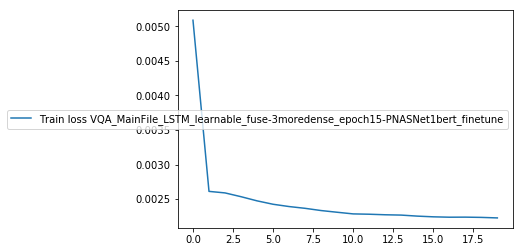

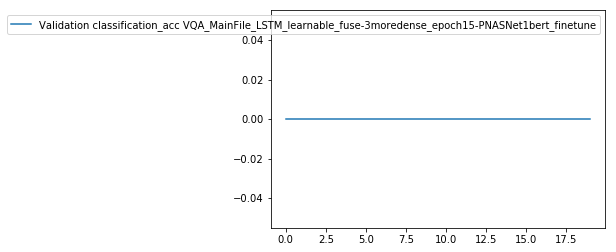

In [39]:
plt.figure()
plt.plot(train_loss, label='Train loss '+ condition)
plt.legend()
plt.show()
plt.figure()
plt.plot(100. * val_acc, label='Validation classification_acc '+ condition)
plt.legend()
plt.show()

In [40]:
print(condition)
print(n_epochs)
print(e)

VQA_MainFile_LSTM_learnable_fuse-3moredense_epoch15-PNASNet1bert_finetune
20
19


# Loading Model for Testing

In [ ]:
print('test')

In [ ]:
try:
    sess.close()
except NameError:
    print("Definining session for the first time")
#tf.reset_default_graph()

In [ ]:
# Deleting Variables to Free Space
del train_images, val_images

In [ ]:
condition = 'VQA_MainFile_LSTM_learnable_fuse-3moredense_epoch15-PNASNet115'
print('Loading grounding pretrained model...')
model_path = '../saved_models/model_'+ condition
print(model_path)
sess, graph = load_model(model_path,config)
print('Model Loaded')

In [ ]:
input_img = sess.graph.get_tensor_by_name("input_img:0")
text_batch = sess.graph.get_tensor_by_name("text_input:0")
mode = sess.graph.get_tensor_by_name("mode:0")
fusion = sess.graph.get_tensor_by_name("VQAClassifier/fusion:0")

# Testing

In [41]:
# Preprocessing Testing Images
valid_ids_test, test_images = preprocess_images(ids_test, txn_test, txn)
print('Done pre-processing test images')

Processed:  0  images
Processed:  3000  images
Processed:  6000  images
Processed:  9000  images
Processed:  12000  images
Processed:  15000  images
Processed:  18000  images
Processed:  21000  images
Processed:  24000  images
Processed:  27000  images
Processed:  30000  images
Processed:  33000  images
Processed:  36000  images
Processed:  39000  images
Processed:  42000  images
Processed:  45000  images
Processed:  48000  images
Processed:  51000  images
Processed:  54000  images
Processed:  57000  images
Processed:  60000  images
Processed:  63000  images
Processed:  66000  images
Processed:  69000  images
Processed:  72000  images
Processed:  75000  images
Processed:  78000  images
Processed:  81000  images
Done pre-processing images
Done pre-processing test images


In [42]:
#print(list(dict_test.keys()))
dict_test['262144']

[{262144000: {'question': 'is the ball flying towards the batter ?'}},
 {262144001: {'question': 'what sport is this ?'}},
 {262144002: {'question': 'can you see the ball ?'}},
 {262144003: {'question': 'is the pitcher wearing a hat ?'}},
 {262144004: {'question': 'will he catch the ball in time ?'}},
 {262144005: {'question': 'what credit card company is on the banner in the background ?'}}]

In [43]:
#Generating All Questions in Answer Batch
final_test_list = []
for k, doc_id in enumerate(dict_test):
    image_id = doc_id
    #print(doc_id)
    for annot in dict_test[doc_id]:
        question_id = list(annot.keys())[0]
        #print(annot[question_id])
        question = annot[question_id]['question']
        ques = Question(question_id ,image_id, question)
        final_test_list.append(ques)

In [44]:
len(final_test_list)
#final_test_list[0].question_id

447793

In [45]:
def generate_batches(questions_list, batch_size):
    n = len(questions_list)
    
    questions_batch = []
    for i, ques in enumerate(questions_list):
        questions_batch.append(ques)
        if ((i + 1) % batch_size == 0) or ((i + 1) == n):
            yield questions_batch
            questions_batch = []

In [46]:
def validate_test(final_test_list, test_images, idx2ans, batch_size):
    results = list()
    print("----started")

    l = 0
    for question_batch in generate_batches(final_test_list, batch_size):
        num_questions = len(question_batch)
        img_batch = np.empty((num_questions, 299, 299, 3))
        ques_batch = []
        ques_ids_batch = []
        
        for j, ques in enumerate(question_batch):
            image_id = ques.image_id
            question_id = ques.question_id
            question = ques.question

            img = np.reshape(test_images[image_id], (299, 299, 3))
            img_batch[j,:] = img
            ques_batch.append(question)
            ques_ids_batch.append(question_id)
        
        input_ids_test,input_mask_test,segment_ids_test =  preprocessbertinputs(ques_batch, tokenizer)
        feed_dict = {input_img: img_batch, input_ids:input_ids_test,input_mask:input_mask_test,segment_ids:segment_ids_test, mode:"test"}
        #feed_dict = {input_img: img_batch, text_batch: ques_batch, mode:"test"}
        pred = sess.run(fusion, feed_dict)
        idx = np.argmax(pred, axis=1)
        for k, each_idx in enumerate(idx):
            results.append({"question_id": ques_ids_batch[k], "answer": idx2ans[each_idx]}) 
        l += 1
        if l % 100 == 0:
            print("Number of batches done: ", l, "; num_results: ", str(len(results)))
    return results

In [ ]:
results = validate_test(final_test_list, test_images, idx2ans, batch_size=64)

----started
Number of batches done:  100 ; num_results:  6400
Number of batches done:  200 ; num_results:  12800
Number of batches done:  300 ; num_results:  19200
Number of batches done:  400 ; num_results:  25600
Number of batches done:  500 ; num_results:  32000
Number of batches done:  600 ; num_results:  38400
Number of batches done:  700 ; num_results:  44800
Number of batches done:  800 ; num_results:  51200
Number of batches done:  900 ; num_results:  57600
Number of batches done:  1000 ; num_results:  64000
Number of batches done:  1100 ; num_results:  70400
Number of batches done:  1200 ; num_results:  76800
Number of batches done:  1300 ; num_results:  83200
Number of batches done:  3200 ; num_results:  204800
Number of batches done:  3300 ; num_results:  211200
Number of batches done:  3400 ; num_results:  217600
Number of batches done:  3500 ; num_results:  224000
Number of batches done:  3600 ; num_results:  230400
Number of batches done:  3700 ; num_results:  236800


In [48]:
print(len(results))

447793


In [ ]:
#writing results to disk
import pickle
f = open('model_'+ condition +'_results.pkl', "wb")
pickle.dump(results, f)
f.close()

In [49]:
#Saving as json file to fetch to server
import json 
with open('model_'+ condition + '20_results.json', 'w') as fp:
    json.dump(results, fp)

In [50]:
print(condition)

VQA_MainFile_LSTM_learnable_fuse-3moredense_epoch15-PNASNet1bert_finetune


In [ ]:
print(len(results))

# Result Analysis

In [ ]:
import pickle
with open('./logs/loss_VQA_MainFile_Pretrained1.pickle', 'rb') as f:
    p = pickle.load(f)

In [ ]:
p